In [1]:
# 모듈 호출
import os
import sys
import glob
import shutil
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import mobilenet, mobilenet_v3, MobileNet
from tensorflow.keras.models import Sequential,Model 
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Dropout,MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
img_size = 224
channel=3

In [5]:
train_datagen = ImageDataGenerator( 
        rescale=1./255,         # 픽셀 값을 0~1 범위로 변환
        rotation_range=40,      # 40도까지 회전
        width_shift_range=0.2,  # 20%까지 좌우 이동
        height_shift_range=0.2, # 20%까지 상하 이동
        shear_range=0.2,        # 20%까지 기울임
        zoom_range=0.2,         # 20%까지 확대
        horizontal_flip=True,   # 좌우 뒤집기
    )
train_generator = train_datagen.flow_from_directory(
    './dataset/train_10',
    batch_size=50,      
    class_mode='categorical', 
    target_size=(img_size, img_size)) 
valid_datagen = ImageDataGenerator(rescale=1./255) # 스케일링만 진행
valid_generator = valid_datagen.flow_from_directory(
    './dataset/valid_10',
    batch_size=20,      
    class_mode='categorical', 
    target_size=(img_size, img_size))
test_datagen = ImageDataGenerator(rescale=1./255) # 스케일링만 진행
test_generator = test_datagen.flow_from_directory(
    './dataset/test_10',
    batch_size=10,      
    class_mode='categorical', 
    target_size=(img_size, img_size),
    shuffle=False)

Found 10529 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


In [6]:
print('train_generator class : ', train_generator.class_indices)
print('valid_generator class : ', valid_generator.class_indices)
print('test_generator class : ', test_generator.class_indices)

train_generator class :  {'갈아만든배': 0, '레쓰비': 1, '마운틴듀': 2, '밀키스': 3, '스프라이트': 4, '칠성사이다': 5, '코카콜라': 6, '트로피카나망고': 7, '펩시콜라': 8, '환타오렌지': 9}
valid_generator class :  {'갈아만든배': 0, '레쓰비': 1, '마운틴듀': 2, '밀키스': 3, '스프라이트': 4, '칠성사이다': 5, '코카콜라': 6, '트로피카나망고': 7, '펩시콜라': 8, '환타오렌지': 9}
test_generator class :  {'갈아만든배': 0, '레쓰비': 1, '마운틴듀': 2, '밀키스': 3, '스프라이트': 4, '칠성사이다': 5, '코카콜라': 6, '트로피카나망고': 7, '펩시콜라': 8, '환타오렌지': 9}


### 모델 학습하기 - MobileNetV2
- imagenet 전이학습
- 은닉층
    * Flatten()
- 출력층
    * Dense(10, activation='softmax')
- complie
    * optimizer : adam
    * loss : categorical_crossentropy
    * metrics : accuracy

In [7]:
# 파라미터 설정
classes = len(train_generator.class_indices)
epochs = 200
batch_size = 32

In [8]:
MobileNet = tf.keras.applications.MobileNetV2(include_top=False,
                                              weights='imagenet',
                                              input_shape=(224,224,3))
MobileNet.trainable = False # 학습으로 기존 가중치 갱신을 하지 않도록 지정

9420800/9406464 [==============================] - 0s 0us/step


In [9]:
# 기본 모델의 아키텍쳐 살펴보기
MobileNet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [10]:
model = Sequential()
model.add(MobileNet)
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 10)                627210    
                                                                 
Total params: 2,885,194
Trainable params: 627,210
Non-trainable params: 2,257,984
_________________________________________________________________


In [11]:
# 모델 환경설정
model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [12]:
model_name = './model/flatten_{epoch:02d}-{val_loss:.4f}.hdf5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = model_name,
                                                 save_weights_only=True, 
                                                 save_freq="epoch")
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

In [13]:
history = model.fit(train_generator,
                    steps_per_epoch=200, 
                    epochs=epochs, 
                    validation_data=valid_generator, 
                    validation_steps=40,
                    callbacks = [[earlystop, cp_callback]]) 

Epoch 1/200
200/200 [==============================] - 3518s 18s/step - loss: 1.4277 - accuracy: 0.8449 - val_loss: 0.2917 - val_accuracy: 0.9438
Epoch 2/200
200/200 [==============================] - 329s 2s/step - loss: 0.5189 - accuracy: 0.9365 - val_loss: 0.2956 - val_accuracy: 0.9625
Epoch 3/200
200/200 [==============================] - 147s 736ms/step - loss: 0.4497 - accuracy: 0.9526 - val_loss: 0.1677 - val_accuracy: 0.9800
Epoch 4/200
200/200 [==============================] - 133s 663ms/step - loss: 0.4517 - accuracy: 0.9583 - val_loss: 0.1927 - val_accuracy: 0.9800
Epoch 5/200
200/200 [==============================] - 130s 651ms/step - loss: 0.4207 - accuracy: 0.9654 - val_loss: 0.2070 - val_accuracy: 0.9775
Epoch 6/200
200/200 [==============================] - 130s 650ms/step - loss: 0.3667 - accuracy: 0.9689 - val_loss: 0.0828 - val_accuracy: 0.9875
Epoch 7/200
200/200 [==============================] - 130s 651ms/step - loss: 0.4735 - accuracy: 0.9669 - val_loss: 0.128

In [17]:
max(history.history['accuracy'])

0.9817616939544678

In [20]:
# 모델 저장
accuracy = round(max(history.history['accuracy'])*100,0)
model.save(f'./model/MobileNetV2_flatten_model_ep{epochs}_acc{accuracy}.h5') # 최종 모델 저장

In [21]:
model.evaluate(test_generator)

50/50 [==============================] - 158s 3s/step - loss: 0.2342 - accuracy: 0.9760


[0.23423048853874207, 0.9760000109672546]

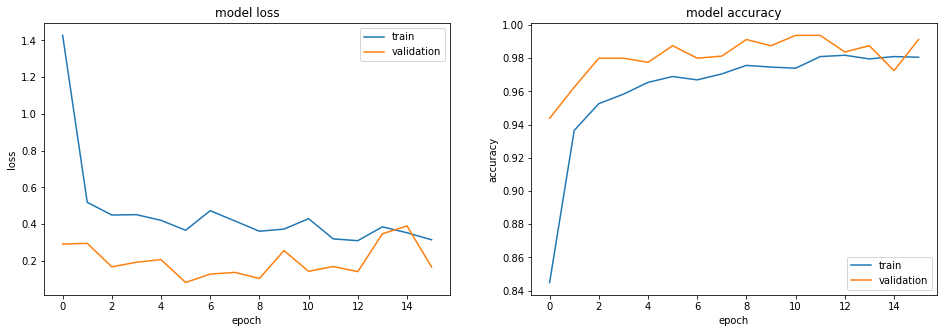

In [22]:
plt.figure(figsize=(16,5))

# 만들어진 모델에 대해 train dataset과 validation dataset의 loss 를 그래프로 표현해 봅니다.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc=0)

# 만들어진 모델에 대해 train dataset과 validation dataset의 accuracy 를 그래프로 표현해 봅니다.
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc=0)

In [23]:
train_generator.class_indices

{'갈아만든배': 0,
 '레쓰비': 1,
 '마운틴듀': 2,
 '밀키스': 3,
 '스프라이트': 4,
 '칠성사이다': 5,
 '코카콜라': 6,
 '트로피카나망고': 7,
 '펩시콜라': 8,
 '환타오렌지': 9}

In [27]:
test_img = cv2.imread('./Pepsi_cola.jpg')  # 펩시콜라 : 8
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img = cv2.resize(test_img,(224,224))/255.0
test_img = test_img.reshape((1,)+test_img.shape)
model.predict(test_img)
# 레쓰비로 판별... why?

array([[0.0000000e+00, 1.0000000e+00, 6.6183593e-21, 2.9262925e-26,
        6.5343123e-16, 0.0000000e+00, 3.2798438e-11, 0.0000000e+00,
        8.3236494e-11, 3.2526443e-11]], dtype=float32)

In [25]:
test_img = cv2.imread('./fanta_orange.jpg')  # 환타오렌지 : 9
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img = cv2.resize(test_img,(224,224))/255.0
test_img = test_img.reshape((1,)+test_img.shape)
model.predict(test_img)
# 판별 성공

array([[6.7470971e-35, 2.4068419e-29, 0.0000000e+00, 0.0000000e+00,
        5.7055597e-35, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        5.6700141e-37, 1.0000000e+00]], dtype=float32)